In [16]:
from glob import glob
import pandas as pd
import json
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import matplotlib.font_manager as fm

In [17]:
fm.fontManager.addfont("./style/Lato/Lato-Regular.ttf")
plt.rcParams["font.family"] = "Lato"
plt.style.use("style/lato_modern.mplstyle")

# Auswertung der Ergebnisse

Auf dem Zukunftskongress 2025 haben wir interessierte Personen das Spiel Postkorb Panic spielen lassen. Die Spielenden waren Personen, die mit dem öffentlichen Sektor zu tun haben. Dazu zählen Personen aus dem öffentlichen Sektor und Personen, die Auftragnehmer für den öffentlichen Sektor sind.

Dieses Notebook macht eine Auswertung der Ergebnisse.

In [18]:
files = glob("../results/*.json")

In [19]:
files

['../results\\Postkorb-Panic_Ergebnisse.json']

In [20]:
feedback = []

for file in files:
    with open(file, encoding = "utf-8") as f:
        feedback.extend(json.load(f))

In [21]:
feedback_data = []

for game_id, f in enumerate(feedback):
    for question_id, result in enumerate(f["gameResults"]):
        d = {col: val for col, val in f.items() if col != "gameResults"}
        d["game_id"] = game_id
        d["question_pos"] = question_id
        for col, value in result.items():
            d[col] = value
        feedback_data.append(d)

In [22]:
feedback_data = pd.DataFrame(feedback_data)

In [23]:
feedback_data["aiCorrect"] = (feedback_data["correctDept"] == feedback_data["aiSuggestion"])
feedback_data["aiAgrees"] = (feedback_data["playerChoice"] == feedback_data["aiSuggestion"])

In [24]:
feedback_data.head()

,name,email,score,totalTime,aiMode,correct,date,game_id,question_pos,text,correctDept,playerChoice,aiSuggestion,isCorrect,responseTime,aiCorrect,aiAgrees
0,Paul,,0.0,131.7,False,5,2025-06-18T09:02:28.518Z,0,0,"Sehr geehrte Damen und Herren,\n\nich hoffe, e...",Leitungsebene,Rechtsabteilung,Leitungsebene,False,6.802,True,False
1,Paul,,1.7,131.7,False,5,2025-06-18T09:02:28.518Z,0,1,"Hey,\n\nwie sieht's eigentlich aus mit nem Ges...",Leitungsebene,Leitungsebene,Leitungsebene,True,10.979,True,True
2,Paul,,0.0,131.7,False,5,2025-06-18T09:02:28.518Z,0,2,"Sehr geehrte Damen und Herren,\n\nich hoffe, e...",Finanzabteilung,Rechtsabteilung,Finanzabteilung,False,18.815,True,False
3,Paul,,0.0,131.7,False,5,2025-06-18T09:02:28.518Z,0,3,"Sehr geehrte Damen und Herren,\n\nich hoffe, e...",Leitungsebene,Kundenservice,Leitungsebene,False,13.363,True,False
4,Paul,,2.5,131.7,False,5,2025-06-18T09:02:28.518Z,0,4,"Hallo allerseits,\n\nich hoffe, Ihnen geht es ...",Kundenservice,Kundenservice,Kundenservice,True,9.382,True,True


# Wie sehr vertrauen Menschen auf die KI?

In [25]:
rows_with_ai = feedback_data[feedback_data["aiMode"]]
print(rows_with_ai.shape)
print(rows_with_ai["aiAgrees"].mean())
print(rows_with_ai[rows_with_ai["aiCorrect"]]["aiAgrees"].mean())
print(rows_with_ai[~rows_with_ai["aiCorrect"]]["aiAgrees"].mean())
print((~rows_with_ai["aiCorrect"]).sum())
ai_agreement_with_ai = [
    rows_with_ai[rows_with_ai["aiCorrect"]]["aiAgrees"].mean(),
    rows_with_ai[~rows_with_ai["aiCorrect"]]["aiAgrees"].mean()
]

(550, 17)
0.9018181818181819
0.9090909090909091
0.7272727272727273
22


In [26]:
rows_sans_ai = feedback_data[~feedback_data["aiMode"]]
print(rows_sans_ai.shape)
print(rows_sans_ai["aiAgrees"].mean())
print(rows_sans_ai[rows_sans_ai["aiCorrect"]]["aiAgrees"].mean())
print(rows_sans_ai[~rows_sans_ai["aiCorrect"]]["aiAgrees"].mean())
print((~rows_sans_ai["aiCorrect"]).sum())
ai_agreement_sans_ai = [
    rows_sans_ai[rows_sans_ai["aiCorrect"]]["aiAgrees"].mean(),
    rows_sans_ai[~rows_sans_ai["aiCorrect"]]["aiAgrees"].mean()
]

(250, 17)
0.704
0.7257383966244726
0.3076923076923077
13


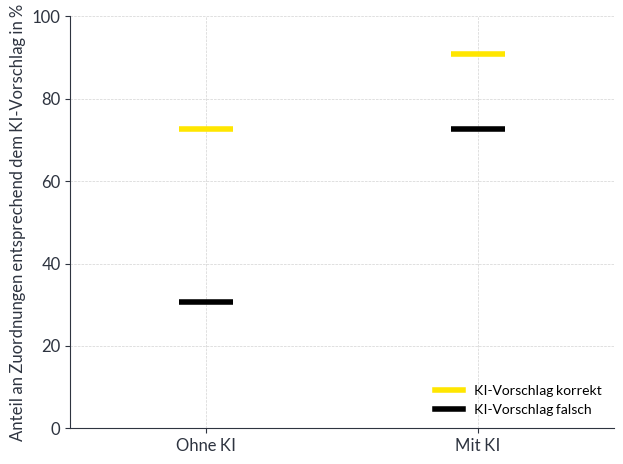

In [27]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

x_pos = [0, 1]

# Plot vorbereiten
fig, ax = plt.subplots()

# Vertikale Linien bei "ohne KI" (x=0)
ax.hlines(xmin=-0.1, xmax=0.1, y=ai_agreement_sans_ai[0]*100, color='#FFE600', linewidth=4, label='ohne KI - grau')
ax.hlines(xmin=-0.1, xmax=0.1, y=ai_agreement_sans_ai[1]*100, color='black', linewidth=4, label='ohne KI - gelb')

# Vertikale Linien bei "mit KI" (x=1)
ax.hlines(xmin=0.9, xmax=1.1, y=ai_agreement_with_ai[0]*100, color="#FFE600", linewidth=4, label='mit KI - grau')
ax.hlines(xmin=0.9, xmax=1.1, y=ai_agreement_with_ai[1]*100, color='black', linewidth=4, label='mit KI - gelb')

# X-Achse beschriften
ax.set_xticks([0, 1])
ax.set_xticklabels(['Ohne KI', 'Mit KI'])

# Y-Achse optional formatieren
ax.set_ylabel('Anteil an Zuordnungen entsprechend dem KI-Vorschlag in %')
ax.set_ylim(0, 100)
ax.set_xlim(-0.5, 1.5)

legende = [
    Line2D([0], [0], color='#FFE600', linewidth=4, label='KI-Vorschlag korrekt'),
    Line2D([0], [0], color='black', linewidth=4, label='KI-Vorschlag falsch')
]
ax.legend(handles=legende, loc="lower right")

# Anzeigen
plt.tight_layout()
plt.savefig("./bilder/Uebernehmen_KI_Vorschlaege.pdf")
plt.show()


# Betrachtung der richtig zugeordneten Anfragen bei falschem KI-Vorschlag

In [28]:
from scipy import stats

#print(feedback_data[feedback_data.isCorrect & ~feedback_data.aiCorrect].responseTime.mean())
median_improvement_times = feedback_data[feedback_data.isCorrect & ~feedback_data.aiCorrect].responseTime
print(median_improvement_times.median())
median_otherwise_times = feedback_data[~(feedback_data.isCorrect & ~feedback_data.aiCorrect)].responseTime
print(median_otherwise_times.median())

# Use Mann–Whitney U test (non-parametric)
u_stat, p_value = stats.mannwhitneyu(median_improvement_times, median_otherwise_times, alternative="greater")

print(f"P-value: {p_value * 100}%")

alpha = 0.01
if p_value < alpha:
    print(
        "Result: Significant difference — AI-Mode has higher scores than Non-AI-Mode."
    )
else:
    print("Result: No significant difference found.")

print(feedback_data[feedback_data.isCorrect & ~feedback_data.aiCorrect].groupby('aiMode').agg({'responseTime': 'median'}))
print(feedback_data[feedback_data.isCorrect & ~feedback_data.aiCorrect].aiMode.value_counts())

11.414
6.881
P-value: 0.33068884705630225%
Result: Significant difference — AI-Mode has higher scores than Non-AI-Mode.
        responseTime
aiMode              
False          9.131
True          13.690
aiMode
True     6
False    5
Name: count, dtype: int64


In [29]:
rectified_text_counts = feedback_data[feedback_data.isCorrect & ~feedback_data.aiCorrect].text.value_counts()
rectified_texts = rectified_text_counts.index
rectified_texts_occur = feedback_data[feedback_data.text.isin(rectified_texts)].text.value_counts()
pd.concat([rectified_text_counts, rectified_texts_occur], axis=1, keys=['Gefunden', 'Vorgekommen']).fillna(0).astype(int)

,Gefunden,Vorgekommen
text,,
"Sehr geehrte Damen und Herren,\n\nhiermit möchte ich Ihnen mitteilen, dass sich in meinen persönlichen Daten eine Änderung ergeben hat. Diese Anpassung betrifft meine Kontaktdaten, die in Ihren Unterlagen aktualisiert werden sollten, um zukünftigen Schriftverkehr reibungslos und zeitnah zu gewährleisten.\n\nVor allem möchte ich betonen, dass meine aktuelle Adresse nun wie folgt lautet: Sonnengasse 12, 12345 Musterdorf. Diese Neuregelung resultiert aus einem kürzlichen Umzug und soll sicherstellen, dass alle relevanten Informationen mich weiterhin ohne Verzögerungen erreichen können.\n\nDarüber hinaus möchte ich Ihnen mitteilen, dass es ebenfalls eine Änderung meines Namens gibt. Aufgrund einer persönlichen Entscheidung trage ich jetzt den Namen Alex Mustermann. Diese Anpassung ist bereits beim Einwohnermeldeamt registriert, sodass alle notwendigen behördlichen Anforderungen erfüllt sind.\n\nIch bitte um zeitnahe Aktualisierung dieser Informationen in meiner Mitarbeiterakte. Sollten Sie weitere Dokumente benötigen, stehe ich Ihnen natürlich gerne zur Verfügung, um den reibungslosen Ablauf der Anpassung zu unterstützen.\n\nVielen Dank im Voraus für Ihre Unterstützung und Kooperation. \n\nMit freundlichen Grüßen,\n\nAlex Mustermann",4,4
"Hallo,\n\nich hab da mal eine Frage, die ich echt gern mit jemandem von euch klären würde, der sich so richtig gut auskennt und Entscheidungsgewalt hat, wenn möglich. Mir ist nämlich zu Ohren gekommen, dass es Änderungen in der Zuweisung der Fördermittel für kulturelle Projekte geben soll, konkret für die Projekte in der Region um Wildberg. Unsere kleine Initiative “Kultur am Fluss” ist besonders interessiert an den Förderungen für das kommende Jahr, da wir planen, das lokale Kunstfestival zu erweitern, und ich würde gerne wissen, ob wir da in die aktuellen Planungen irgendwie eingebunden werden können oder zumindest ehrlich Bescheid kriegen, wie der Hase läuft.\n\nOh, übrigens, unser Verein hat das letzte Jahr dieses Nachwuchs-Kunstprojekt „Junge Talente am Fluss“ veranstaltet, was ja im Bericht von eurer Verwaltung super positives Feedback bekommen hat, wenn ich mich recht erinnere. Wäre klasse, wenn jemand die Zeit für ein kurzes Gespräch fände, um zu schauen, wie unsere Interessen da reinpassen könnten. Am besten wäre nächste oder übernächste Woche, ich bin da recht flexibel. Ich würde echt ungern weiter mit anderen Instanzen plaudern ohne dass die Möglichkeit besteht, direkt mit euch was auszuknobeln. \n\nWär super, wenn wir da was arrangieren könnten.\n\nViele Grüße,\n\nUlli Unverhofft",3,4
"hey leute,\n\nkönnt ihr mir mal das formular zuhaun, das ich für die abwicklung von diesen geförderten projekten brauch? glaub irgendwas mit m3-xyz echt umständlicher name, oder so. muss dringend prüfen ob ich meine Genehmigungen beim bauamt noch verschärfen kann. ist wichtig, sonst gibts problem mit unserer kostenplanung bei bühlmeister & co. ihr müsst das doch eh griffbereit haben, incl. info´s und sowas, oder? am besten emailen oder fax, ja das gibts noch verrückt ik weiß... bevor ihr wieder alles jahre dauert bis was läuft.\n\ngruß \nbodo schmidt",2,4
"Hallo,\n\nich hoffe Sie haben genau so schönes Wetter wie ich hier zuhause in Kleinstadt. Also, ich schreibe wegen eine Idee die mir eingefallen ist, wegen die Richtlinie, die haben Sie doch auch bestimmt gesehen, oder? Das mit den neuen Verkehrsschildern, die ja fast keiner versteht und schon gar keiner den Sinn davon weiß, vor allem nicht in der Adalbertstraße 7 bei Max und Egon GmbH. Das müsste einfach mal jemand mit Überblick anschauen, kam mir so in den Kopf, weil das da doch besonders große Laster betrifft. Ich meine, es muss doch jemand geben, der sehen kann, dass was gar nicht klar ist und dann kann man das doch irgendwie ändern, bevor noch mehr Chaos wird.\n\nWeiß nicht, ob das so gut ist, aber rede doch vielleicht einfach mal mit den Höhergestellten, die mehr Plan haben. Da gibt’s doch bestimmt jemanden, der mal

In [30]:
source_data_path = "../data/data.json"
with open(source_data_path, encoding = "utf-8") as f:
        source_data = pd.DataFrame(json.load(f))


In [31]:
print(len(feedback_data[~feedback_data.aiCorrect].text.value_counts()))
print((source_data.label != source_data.prediction).sum())

12
12


# Einflussfaktoren für unterschiedliche Ergebnisse

## Gibt es einen systematischen Unterschied zwischen schnellen Entscheidern und ausführlichen Lesern?

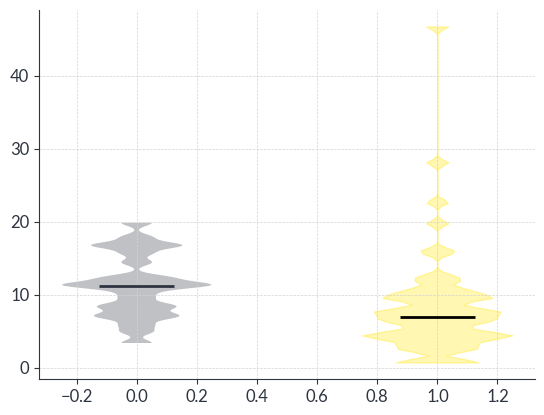

In [32]:
time_sequences_with_ai = pd.DataFrame(rows_with_ai["responseTime"].values.reshape(-1, 10))
time_sequences_with_ai.head()
time_means_with_ai = time_sequences_with_ai.mean(axis=1)

time_sequences_sans_ai = pd.DataFrame(rows_sans_ai["responseTime"].values.reshape(-1, 10))
time_sequences_sans_ai.head()
time_means_sans_ai = time_sequences_sans_ai.mean(axis=1)

plt.violinplot([time_means_sans_ai], positions=[0], showmedians=True, showextrema=False, bw_method=0.1)
a = plt.violinplot([time_means_with_ai], positions=[1], showmedians=True, showextrema=False, bw_method=0.05)
for pc in a["bodies"]:  # type: ignore
    pc.set_color("#FFE600")
a["cmedians"].set_colors("black")  # type: ignore

# plt.ylabel("Durchschnittliche Dauer pro Frage")
# plt.xticks([0, 1], labels=["Ohne KI", "Mit KI"])
# plt.ylim(0, 30)
# plt.show()


# plt.figure(figsize=(8, 5))
# for i, row in time_sequences_with_ai.iterrows():
#     plt.plot(row.values, label=f"Zeile {i}")

# plt.xlabel('Spaltenindex')
# plt.ylabel('Wert')
# plt.title('Zeilen als Kurven')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.ylim(0, 30)
# plt.show()


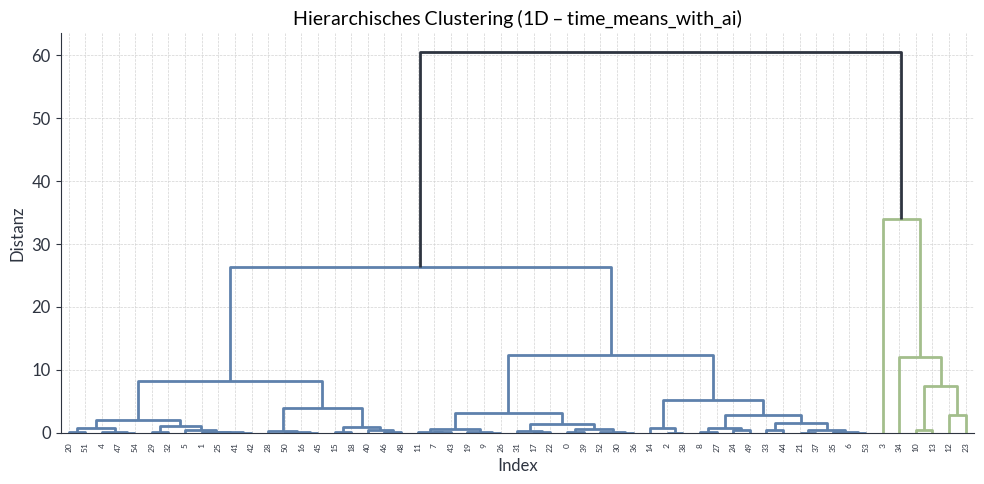

In [33]:
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Falls du die Series schon hast:
# time_means_with_ai = pd.Series([...])

# In 2D-Array umformen für Clustering
X = time_means_with_ai.values.reshape(-1, 1)

# Hierarchisches Clustering durchführen
Z = linkage(X, method='ward')

# Dendrogramm plotten
plt.figure(figsize=(10, 5))
dendrogram(Z, labels=time_means_with_ai.index.astype(str))  # Index als Label
plt.title("Hierarchisches Clustering (1D – time_means_with_ai)")
plt.xlabel("Index")
plt.ylabel("Distanz")
plt.tight_layout()
plt.show()

       Wert  Cluster
0    6.5898        2
1    4.4064        1
2   11.9913        2
3   46.7345        4
4    4.2104        1
5    4.8297        1
6    9.4969        2
7    7.4019        2
8   10.3802        2
9    7.9484        2
10  16.1452        3
11   7.5997        2
12  22.6685        3
13  15.6347        3
14  12.6956        2
15   2.9238        1
16   0.7428        1
17   6.1737        2
18   3.0936        1
19   7.7800        2
20   3.6570        1
21   9.7986        2
22   6.0917        2
23  19.7683        3
24  11.0930        2
25   4.5769        1
26   7.9287        2
27  10.2384        2
28   0.9470        1
29   5.2352        1
30   6.9769        2
31   5.8834        2
32   5.1569        1
33   8.4356        2
34  28.0912        3
35   9.3537        2
36   6.9656        2
37   9.8067        2
38  12.0303        2
39   6.5132        2
40   2.2049        1
41   4.4873        1
42   4.5189        1
43   7.4979        2
44   8.9405        2
45   0.7869        1
46   2.6588  

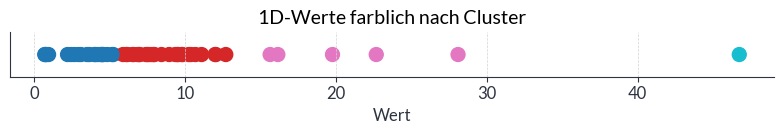

In [34]:
# Cluster-Labels extrahieren (z. B. 2 Cluster)
labels = fcluster(Z, t=4, criterion='maxclust')

# Ergebnis anzeigen
time_means_with_ai_clustered = pd.DataFrame({
    'Wert': time_means_with_ai.values,
    'Cluster': labels
})

print(time_means_with_ai_clustered)

# Optional: 1D-Punkte farbig nach Cluster anzeigen
plt.figure(figsize=(8, 1.5))
plt.scatter(X[:, 0], np.zeros_like(X), c=labels, cmap='tab10', s=100)
plt.yticks([])
plt.title("1D-Werte farblich nach Cluster")
plt.xlabel("Wert")
plt.tight_layout()
plt.show()

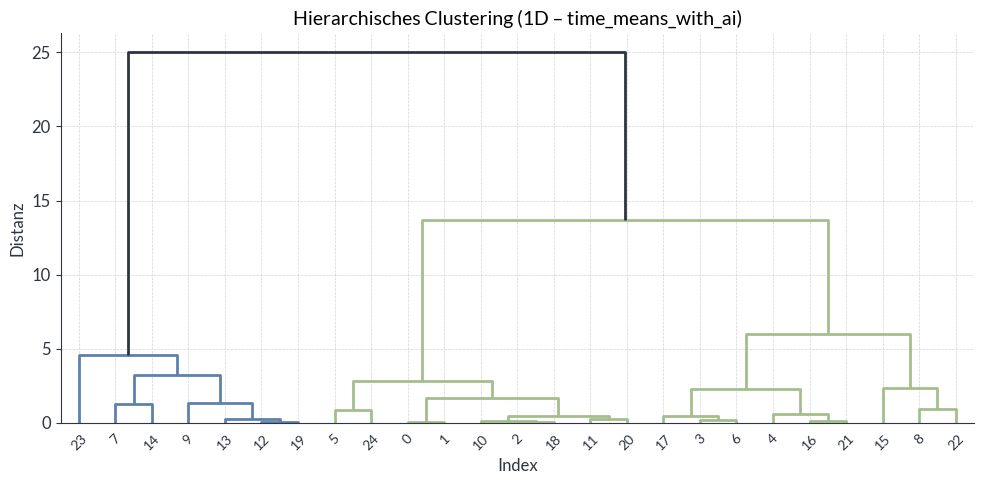

In [35]:
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Falls du die Series schon hast:
# time_means_with_ai = pd.Series([...])

# In 2D-Array umformen für Clustering
X = time_means_sans_ai.values.reshape(-1, 1)

# Hierarchisches Clustering durchführen
Z = linkage(X, method='ward')

# Dendrogramm plotten
plt.figure(figsize=(10, 5))
dendrogram(Z, labels=time_means_sans_ai.index.astype(str))  # Index als Label
plt.title("Hierarchisches Clustering (1D – time_means_with_ai)")
plt.xlabel("Index")
plt.ylabel("Distanz")
plt.tight_layout()
plt.show()

       Wert  Cluster
0   12.2919        2
1   12.3696        2
2   11.2307        2
3    7.1035        3
4    8.0005        3
5    9.5821        2
6    7.2598        3
7   14.4198        1
8    4.9137        3
9   17.8488        1
10  11.1611        2
11  11.4113        2
12  16.8379        1
13  16.6104        1
14  15.6923        1
15   3.3623        3
16   8.6000        3
17   6.7633        3
18  11.2536        2
19  16.8117        1
20  11.6388        2
21   8.4553        3
22   5.8216        3
23  19.8379        1
24  10.4450        2


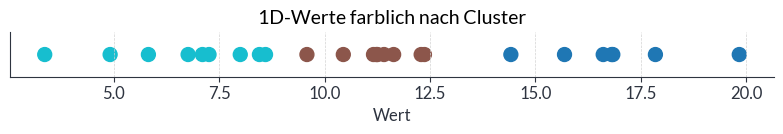

In [36]:
# Cluster-Labels extrahieren (z. B. 2 Cluster)
labels = fcluster(Z, t=3, criterion='maxclust')

# Ergebnis anzeigen
time_means_with_ai_clustered = pd.DataFrame({
    'Wert': time_means_sans_ai.values,
    'Cluster': labels
})

print(time_means_with_ai_clustered)

# Optional: 1D-Punkte farbig nach Cluster anzeigen
plt.figure(figsize=(8, 1.5))
plt.scatter(X[:, 0], np.zeros_like(X), c=labels, cmap='tab10', s=100)
plt.yticks([])
plt.title("1D-Werte farblich nach Cluster")
plt.xlabel("Wert")
plt.tight_layout()
plt.show()

## Welche Abteilungen waren besonders schwierig?

In [111]:
round(pd.crosstab(feedback_data.correctDept, feedback_data.playerChoice, normalize='index')*100)

playerChoice,Finanzabteilung,Kundenservice,Leitungsebene,Personalabteilung,Rechtsabteilung
correctDept,,,,,
Finanzabteilung,88.0,1.0,5.0,1.0,5.0
Kundenservice,4.0,81.0,6.0,4.0,4.0
Leitungsebene,2.0,16.0,76.0,1.0,6.0
Personalabteilung,0.0,4.0,4.0,90.0,2.0
Rechtsabteilung,1.0,15.0,4.0,2.0,79.0


In [165]:
groupBy_corr_ai = feedback_data.groupby(["correctDept", "aiMode"])
groupBy_corr_ai_aggs = groupBy_corr_ai.agg({"responseTime": "median", "isCorrect": "mean", "score": "median"})
groupBy_corr_ai_aggs

responseTime  isCorrect  score
correctDept       aiMode                                
Finanzabteilung   False         7.9170   0.767442   2.20
                  True          4.3065   0.931373   8.85
Kundenservice     False        11.1650   0.680851   0.90
                  True          6.5810   0.871560   4.80
Leitungsebene     False        10.9790   0.666667   0.60
                  True          7.8650   0.805825   2.70
Personalabteilung False         7.3400   0.840000   3.75
                  True          4.5905   0.928571   8.70
Rechtsabteilung   False         9.0150   0.603774   1.00
                  True          6.9395   0.872727   4.00

In [166]:
groupBy_picked_ai = feedback_data.groupby(["playerChoice", "aiMode"])
groupBy_picked_ai_aggs = groupBy_picked_ai.agg({"responseTime": "median", "isCorrect": "mean", "score": "median"})
groupBy_picked_ai_aggs

responseTime  isCorrect  score
playerChoice      aiMode                                
Finanzabteilung   False         7.8315   0.868421   3.65
                  True          4.3065   0.931373   8.85
Kundenservice     False        11.8630   0.542373   0.20
                  True          6.7330   0.760000   3.60
Leitungsebene     False        11.1880   0.703704   0.75
                  True          7.5325   0.864583   3.40
Personalabteilung False         6.5810   0.823529   3.70
                  True          4.4330   0.966942   9.00
Rechtsabteilung   False         9.2975   0.666667   1.50
                  True          7.0900   0.905660   4.15

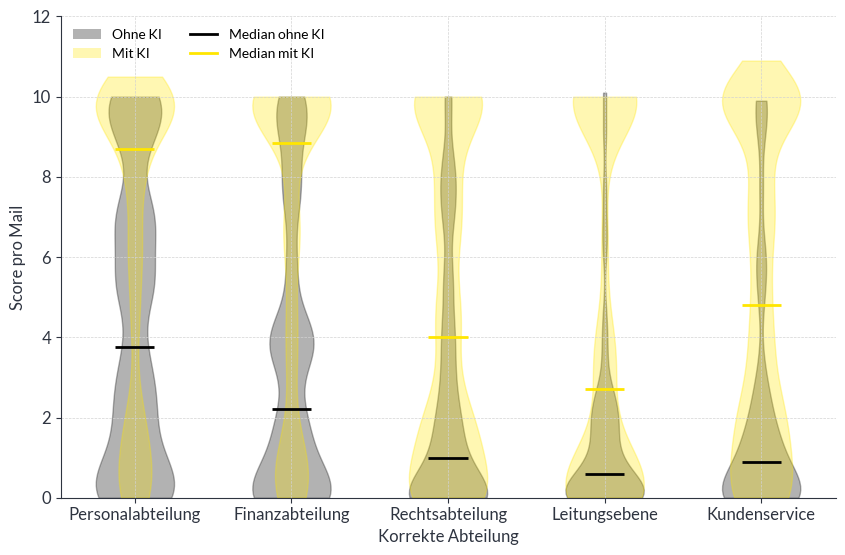

In [176]:
from matplotlib.patches import Patch

groupBy_lists = groupBy_corr_ai.score.apply(list)

depts = [
    "Personalabteilung",
    "Finanzabteilung",
    "Rechtsabteilung",
    "Leitungsebene",
    "Kundenservice",
]

fig, ax = plt.subplots(figsize=(10, 10/8*5))
for i, dept in enumerate(depts):
    b = ax.violinplot([groupBy_lists[(dept, False)]], positions=[i], showmedians=True, showextrema=False, bw_method=0.2)
    for pc in b["bodies"]:  # type: ignore
        pc.set_color("black")
    b["cmedians"].set_colors("black")  # type: ignore
    a = ax.violinplot([groupBy_lists[(dept, True)]], positions=[i], showmedians=True, showextrema=False, bw_method=0.2)
    for pc in a["bodies"]:  # type: ignore
        pc.set_color("#FFE600")
    a["cmedians"].set_colors("#FFE600")  # type: ignore

alpha_black = b['bodies'][0].get_facecolor()[0][3]
alpha_yellow = a['bodies'][0].get_facecolor()[0][3]

legende = [
    Patch(facecolor='black', edgecolor=None, label='Ohne KI', alpha = alpha_black),
    Patch(facecolor='#FFE600', edgecolor=None, label='Mit KI', alpha = alpha_yellow),
    Line2D([0], [0], color='black', linewidth=2, label='Median ohne KI'),
    Line2D([0], [0], color='#FFE600', linewidth=2, label='Median mit KI')
]

ax.legend(loc = 'upper left', handles=legende, ncol = 2)

ax.set_xticks(list(range(5)), depts)
plt.xlabel("Korrekte Abteilung")
plt.ylabel("Score pro Mail")
ax.set_ylim((0, 12))
plt.savefig("./bilder/Scores_pro_Abteilung.pdf")
plt.show()

                            OLS Regression Results                            
Dep. Variable:           responseTime   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.3675
Date:                Mon, 07 Jul 2025   Prob (F-statistic):              0.545
Time:                        15:54:35   Log-Likelihood:                -2894.6
No. Observations:                 800   AIC:                             5793.
Df Residuals:                     798   BIC:                             5802.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       8.3038      1.604      5.177      

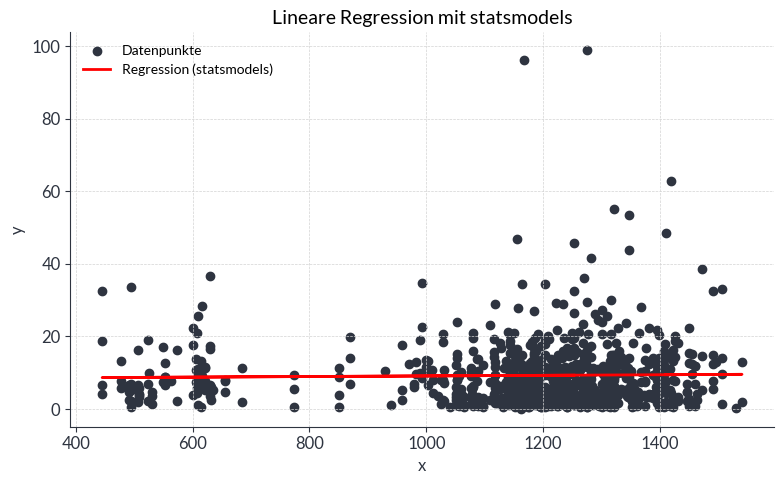

In [158]:
feedback_data["text_length"] = [len(message) for message in feedback_data["text"]]

import statsmodels.formula.api as smf

# Formel: y ~ x (wie in R)
model = smf.ols(formula='responseTime ~ text_length', data=feedback_data).fit()

print(model.summary())

# Vorhersage berechnen
y_hat = model.predict(feedback_data)

# Plot: Datenpunkte + Regressionslinie
plt.figure(figsize=(8, 5))
plt.scatter(feedback_data['text_length'], feedback_data['responseTime'], label='Datenpunkte')
plt.plot(feedback_data['text_length'], y_hat, color='red', label='Regression (statsmodels)')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Lineare Regression mit statsmodels")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# Welche Markierungen waren hilfreich?

## Markierungen als zusätzliche Spalte erstellen

In [42]:
import re

highlight_lists = []
for message in source_data["highlights"]:
    pattern = r"<span class='mark'>(.*?)</span>"
    matches = re.findall(pattern, message)
    highlight_lists.append(matches)

source_data["highlight_lists"] = highlight_lists

feedback_data_marked = feedback_data.merge(source_data[['text', 'highlight_lists']], on='text', how='left')

## Effekt häufiger Markierungen

In [43]:
marked_personal = feedback_data_marked[feedback_data_marked["aiMode"] & (feedback_data_marked['correctDept'] == "Personalabteilung")]
finanz_counts = marked_personal['highlight_lists'].explode().value_counts()
print(finanz_counts.head(20))

marked_finanz = feedback_data_marked[feedback_data_marked["aiMode"] & (feedback_data_marked['correctDept'] == "Finanzabteilung")]
finanz_counts = marked_finanz['highlight_lists'].explode().value_counts()
print(finanz_counts.head(20))

marked_recht = feedback_data_marked[feedback_data_marked["aiMode"] & (feedback_data_marked['correctDept'] == "Rechtsabteilung")]
finanz_counts = marked_recht['highlight_lists'].explode().value_counts()
print(finanz_counts.head(20))

marked_leitung = feedback_data_marked[feedback_data_marked["aiMode"] & (feedback_data_marked['correctDept'] == "Leitungsebene")]
finanz_counts = marked_leitung['highlight_lists'].explode().value_counts()
print(finanz_counts.head(20))

marked_kunden = feedback_data_marked[feedback_data_marked["aiMode"] & (feedback_data_marked['correctDept'] == "Kundenservice")]
finanz_counts = marked_kunden['highlight_lists'].explode().value_counts()
print(finanz_counts.head(20))

highlight_lists
beruflichen             41
berufliche              32
Position                24
Berufserfahrung         24
Fähigkeiten             17
Tätigkeit               17
gearbeitet              16
Informationen           16
Aufgaben                15
gut                     13
Praktikum               13
Bewerbung               13
Unterstützung           12
Tätigkeiten             12
Qualifikationen         11
internen                11
Stellenausschreibung    11
Mitarbeiter             10
Bewerbungen             10
Bestätigung             10
Name: count, dtype: int64
highlight_lists
Euro               19
Informationen      18
Rechnungen         17
Überweisung        16
finanziellen       15
Ausgaben           12
Rechnung           12
finanzielle        11
Zahlung            10
Zahlungsfristen    10
Transaktionen      10
erhalten            9
Mittel              9
Unterstützung       8
Zahlungen           8
Konto               8
Budgets             7
Summe               7
welche

In [173]:
def round_significant(x, digits):
    if pd.isna(x):
        return(np.nan())
    else:
        x = np.asarray(x)
        return np.round(x, -np.floor(np.log10(np.abs(x))).astype(int) + digits - 1)

significant_cases = pd.DataFrame(columns=["Abteilung", "Stichwort", "p-Wert", "Scores mit Stichwort", "Scores ohne Stichwort"])

def marked_words_effects(abteilung, begriff):
    marked_in_abt = feedback_data_marked[feedback_data_marked["aiMode"] & (feedback_data_marked['correctDept'] == abteilung) & feedback_data.aiCorrect]
    begriff_maske = marked_in_abt['highlight_lists'].apply(lambda eintraege: any(begriff in e for e in eintraege) if isinstance(eintraege, list) else False)
    begriff_scores_mit = marked_in_abt[begriff_maske]['score']
    begriff_scores_ohne = marked_in_abt[~begriff_maske]['score']
    p_value = round_significant(stats.mannwhitneyu(begriff_scores_mit, begriff_scores_ohne, alternative="greater")[1], 3)
    if p_value<=0.05:
            global significant_cases
            new_row = pd.DataFrame([{
                 "Abteilung": abteilung,
                 "Stichwort": begriff,
                 "p-Wert": p_value,
                 "Scores mit Stichwort": list(begriff_scores_mit),
                 "Scores ohne Stichwort": list(begriff_scores_ohne)
            }])
            significant_cases = pd.concat([significant_cases, new_row], ignore_index=True)
    return (
        f"Score bei {abteilung} mit '{begriff}' ist {begriff_scores_mit.median()}, und ohne {begriff_scores_ohne.median()}. "
        f"Der p-Wert für 'mit besser als ohne' ist {p_value}."
    )

print(marked_words_effects("Personalabteilung", "beruflich"))
print(marked_words_effects("Personalabteilung", "Tätigkeit"))
print(marked_words_effects("Personalabteilung", "Position"))
print(marked_words_effects("Personalabteilung", "Beruf"))
print(marked_words_effects("Personalabteilung", "Bewerbung"))
print(marked_words_effects("Personalabteilung", "Information"))
print("\n")
print(marked_words_effects("Finanzabteilung", "finanziell"))
print(marked_words_effects("Finanzabteilung", "Zahlung"))
print(marked_words_effects("Finanzabteilung", "Euro"))
print(marked_words_effects("Finanzabteilung", "Information"))
print(marked_words_effects("Finanzabteilung", "Rechnung"))
print(marked_words_effects("Finanzabteilung", "Überweisung"))
print("\n")
print(marked_words_effects("Rechtsabteilung", "rechtlich"))
print(marked_words_effects("Rechtsabteilung", "Dokument"))
print(marked_words_effects("Rechtsabteilung", "Information"))
print(marked_words_effects("Rechtsabteilung", "gesetzlich"))
print(marked_words_effects("Rechtsabteilung", "Vertrag"))
print("\n")
print(marked_words_effects("Leitungsebene", "strategisch"))
print(marked_words_effects("Leitungsebene", "Herausforderung"))
#print(marked_words_effects("Leitungsebene", "Information"))
print("\n")
print(marked_words_effects("Kundenservice", "Antrag"))
print(marked_words_effects("Kundenservice", "Anfrage"))
print(marked_words_effects("Kundenservice", "Formular"))
print(marked_words_effects("Kundenservice", "Information"))
print(marked_words_effects("Kundenservice", "Dokument"))
print(marked_words_effects("Kundenservice", "Online"))

significant_cases = significant_cases.sort_values(by='p-Wert')

print(significant_cases)

Score bei Personalabteilung mit 'beruflich' ist 9.5, und ohne 7.8. Der p-Wert für 'mit besser als ohne' ist 0.183.
Score bei Personalabteilung mit 'Tätigkeit' ist 9.5, und ohne 8.3. Der p-Wert für 'mit besser als ohne' ist 0.081.
Score bei Personalabteilung mit 'Position' ist 9.5, und ohne 8.6. Der p-Wert für 'mit besser als ohne' ist 0.0509.
Score bei Personalabteilung mit 'Beruf' ist 7.449999999999999, und ohne 9.0. Der p-Wert für 'mit besser als ohne' ist 0.473.
Score bei Personalabteilung mit 'Bewerbung' ist 7.8, und ohne 9.1. Der p-Wert für 'mit besser als ohne' ist 0.905.
Score bei Personalabteilung mit 'Information' ist 9.5, und ohne 8.8. Der p-Wert für 'mit besser als ohne' ist 0.329.


Score bei Finanzabteilung mit 'finanziell' ist 9.7, und ohne 7.7. Der p-Wert für 'mit besser als ohne' ist 0.0543.
Score bei Finanzabteilung mit 'Zahlung' ist 9.55, und ohne 6.65. Der p-Wert für 'mit besser als ohne' ist 0.00331.
Score bei Finanzabteilung mit 'Euro' ist 9.5, und ohne 8.7. Der p-

C:\Users\AndreasEberl\AppData\Local\Temp\ipykernel_23672\2857096791.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  significant_cases = pd.concat([significant_cases, new_row], ignore_index=True)


0    0.00331
2    0.03310
1    0.04400
Name: p-Wert, dtype: float64


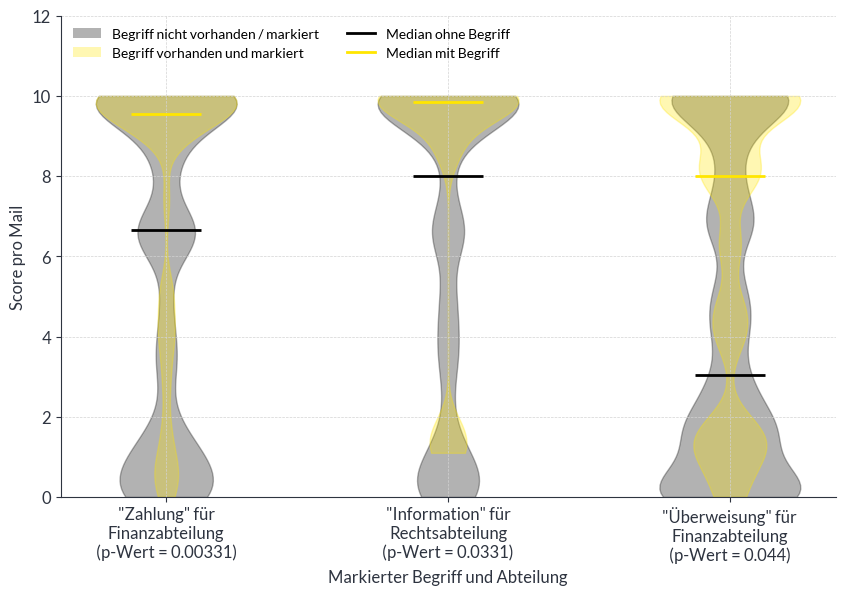

In [175]:
fig, ax = plt.subplots(figsize=(10, 10/8*5))
for i in range(significant_cases.shape[0]):
    b = ax.violinplot([significant_cases['Scores ohne Stichwort'][i]], positions=[i], showmedians=True, showextrema=False, bw_method=0.15)
    for pc in b["bodies"]:  # type: ignore
        pc.set_color("black")
    b["cmedians"].set_colors("black")  # type: ignore
    a = ax.violinplot([significant_cases['Scores mit Stichwort'][i]], positions=[i], showmedians=True, showextrema=False, bw_method=0.15)
    for pc in a["bodies"]:  # type: ignore
        pc.set_color("#FFE600")
    a["cmedians"].set_colors("#FFE600")  # type: ignore

alpha_black = b['bodies'][0].get_facecolor()[0][3]
alpha_yellow = a['bodies'][0].get_facecolor()[0][3]

legende = [
    Patch(facecolor='black', edgecolor=None, label='Begriff nicht vorhanden / markiert', alpha = alpha_black),
    Patch(facecolor='#FFE600', edgecolor=None, label='Begriff vorhanden und markiert', alpha = alpha_yellow),
    Line2D([0], [0], color='black', linewidth=2, label='Median ohne Begriff'),
    Line2D([0], [0], color='#FFE600', linewidth=2, label='Median mit Begriff')
]

print(significant_cases['p-Wert'])

ax.legend(loc = 'upper left', handles=legende, ncol = 2)

tick_names = '"' + significant_cases.Stichwort + '" für\n' + significant_cases.Abteilung + '\n(p-Wert = ' + significant_cases['p-Wert'].astype(str) + ')'
ax.set_xticks(list(range(significant_cases.shape[0])), tick_names)
plt.xlabel("Markierter Begriff und Abteilung")
plt.ylabel("Score pro Mail")
ax.set_ylim((0, 12))
plt.savefig("./bilder/Markierungen.pdf")
plt.show()

# Wird mit der Zeit eher der KI-Vorschlag übernommen?

              aiAgrees  aiCorrect
question_pos                     
0             0.909091   1.000000
1             0.890909   0.963636
2             0.872727   0.927273
3             0.872727   1.000000
4             0.872727   0.909091
5             0.927273   0.981818
6             0.909091   0.963636
7             0.890909   0.927273
8             0.927273   0.927273
9             0.945455   1.000000
              aiAgrees  aiCorrect
question_pos                     
0             0.909091        1.0
1             0.905660        1.0
2             0.901961        1.0
3             0.872727        1.0
4             0.880000        1.0
5             0.925926        1.0
6             0.905660        1.0
7             0.901961        1.0
8             0.941176        1.0
9             0.945455        1.0
              aiAgrees  aiCorrect
question_pos                     
1                 0.50        0.0
2                 0.50        0.0
4                 0.80        0.0
5             

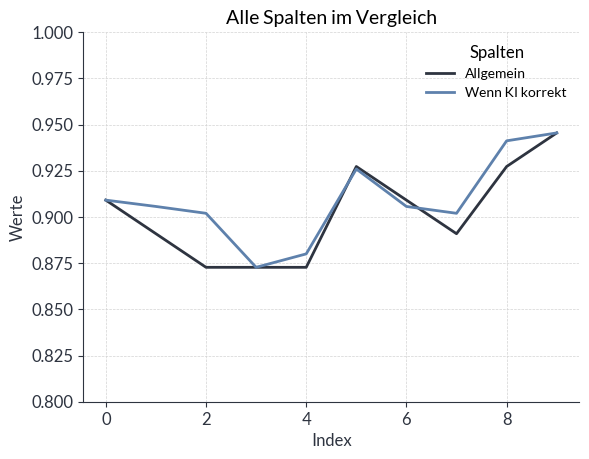

In [156]:
print(rows_with_ai.groupby("question_pos").agg({'aiAgrees': 'mean', 'aiCorrect': 'mean'}))
print(rows_with_ai[rows_with_ai['aiCorrect']].groupby("question_pos").agg({'aiAgrees': 'mean', 'aiCorrect': 'mean'}))
print(rows_with_ai[~rows_with_ai['aiCorrect']].groupby("question_pos").agg({'aiAgrees': 'mean', 'aiCorrect': 'mean'}))
aiAgree_by_pos = rows_with_ai.groupby("question_pos").agg({'aiAgrees': 'mean'})
aiAgreeIfCorr_by_pos = rows_with_ai[rows_with_ai['aiCorrect']].groupby("question_pos").agg({'aiAgrees': 'mean'})
aiAgree = pd.concat([aiAgree_by_pos, aiAgreeIfCorr_by_pos], axis=1)
aiAgree.columns = ["Allgemein", "Wenn KI korrekt"]

aiAgree.plot()
plt.ylim((0.8, 1))
plt.title("Alle Spalten im Vergleich")
plt.xlabel("Index")
plt.ylabel("Werte")
plt.legend(title="Spalten")
plt.show()

# Wo gehen die 8% Accuracy-Unterschied zwischen KI und Mensch mit KI verloren?

In [172]:
print(feedback_data.aiCorrect.mean())
print(feedback_data.isCorrect.mean())
print(rows_with_ai.aiCorrect.mean())
print(rows_with_ai.isCorrect.mean())
print(rows_sans_ai.aiCorrect.mean())
print(rows_sans_ai.isCorrect.mean())
print(rows_with_ai[rows_with_ai.aiCorrect & ~rows_with_ai.isCorrect].correctDept.value_counts().sort_index())
print(rows_with_ai[~rows_with_ai.aiCorrect | rows_with_ai.isCorrect].correctDept.value_counts().sort_index())
print(rows_with_ai[rows_with_ai.aiCorrect & ~rows_with_ai.isCorrect].responseTime.median())
print(rows_with_ai[rows_with_ai.aiCorrect & rows_with_ai.isCorrect].responseTime.median())
print(rows_with_ai[~rows_with_ai.aiCorrect & rows_with_ai.isCorrect].responseTime.median())
print(rows_with_ai[~rows_with_ai.aiCorrect & ~rows_with_ai.isCorrect].responseTime.median())
print(rows_with_ai[rows_with_ai.aiCorrect & ~rows_with_ai.isCorrect].question_pos.value_counts().sort_index())
print(rows_with_ai[~rows_with_ai.aiCorrect | rows_with_ai.isCorrect].question_pos.value_counts().sort_index())

0.95625
0.82875
0.96
0.8836363636363637
0.948
0.708
correctDept
Finanzabteilung       7
Kundenservice        11
Leitungsebene        12
Personalabteilung     6
Rechtsabteilung      12
Name: count, dtype: int64
correctDept
Finanzabteilung       95
Kundenservice         98
Leitungsebene         91
Personalabteilung    120
Rechtsabteilung       98
Name: count, dtype: int64
9.006
5.390000000000001
13.69
10.606
question_pos
0    5
1    5
2    5
3    7
4    6
5    4
6    5
7    5
8    3
9    3
Name: count, dtype: int64
question_pos
0    50
1    50
2    50
3    48
4    49
5    51
6    50
7    50
8    52
9    52
Name: count, dtype: int64
